In [1]:
import glob
import logging
import random
import time
import gc

import numpy as np
import matplotlib.pyplot as plt

import cv2
import torchstain

import torch
from torch.utils.data import DataLoader
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2


from patch_dataset import PatchDataset
from class_mapping import NAME2TYPELABELS_MAP
from train_utils import run_train_loop, seed_worker, plot_history
from log_utils import setup_logging

In [2]:
setup_logging()

2023-08-18 22:37:33,263-INFO-Logging setup complete.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"pytorch device using: {device}")

2023-08-18 22:37:33,524-INFO-pytorch device using: cuda


In [4]:
MAGNIFICATION = "*"
COLOR_SPACE = "RGB"

PATCH_PATH = "./data/patches"

# relative to script execution path
OUTPUT_PLOT_PATH = "./output/plots"
MODEL_SAVEPATH = "./models"

In [5]:
# load dataset
train_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/train/**/*-{MAGNIFICATION}"))

train_img_path = []
train_mask_path = []

for roi in train_patches_paths:
    train_img_path.extend(glob.glob(roi + "/patch/*.png"))
    train_mask_path.extend(glob.glob(roi + "/mask/*.png"))

train_img_path.sort()
train_mask_path.sort()

assert len(train_img_path) == len(train_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} train images: {len(train_img_path)}")

val_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/val/**/*-{MAGNIFICATION}"))

val_img_path = []
val_mask_path = []

for roi in val_patches_paths:
    val_img_path.extend(glob.glob(roi + "/patch/*.png"))
    val_mask_path.extend(glob.glob(roi + "/mask/*.png"))

val_img_path.sort()
val_mask_path.sort()

assert len(val_img_path) == len(val_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} val images: {len(val_img_path)}")

2023-08-18 22:37:33,858-INFO-Number of * train images: 67115
2023-08-18 22:37:33,889-INFO-Number of * val images: 5920


In [6]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [7]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

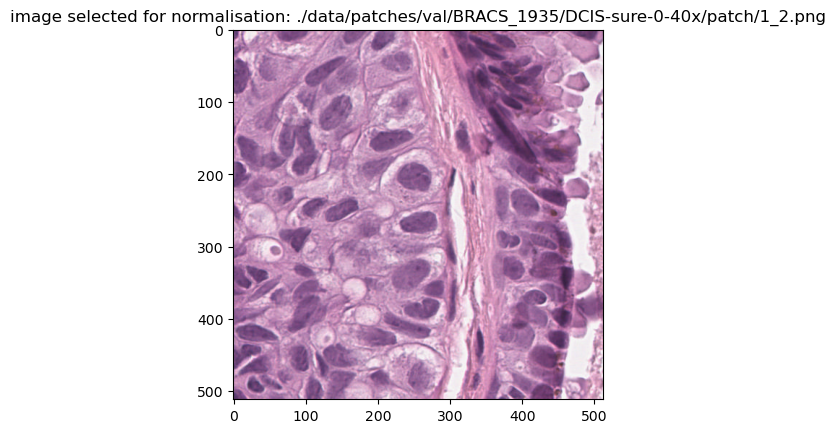

In [8]:
norm_img_path = val_img_path[len(val_img_path)//2]
norm_img_arr = cv2.cvtColor(cv2.imread(norm_img_path), cv2.COLOR_BGR2RGB)
plt.imshow(norm_img_arr)
plt.title(f"image selected for normalisation: {norm_img_path}")
plt.show()

In [9]:
stain_normaliser = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
stain_normaliser.fit(norm_img_arr)

In [10]:
patch_train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode="RGB", name_to_class_mapping=NAME2TYPELABELS_MAP,
    stain_normaliser=stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

patch_val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode="RGB", name_to_class_mapping=NAME2TYPELABELS_MAP,
    stain_normaliser=stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

In [11]:
model = torchvision.models.resnext50_32x4d(num_classes=4)

In [12]:
torch.cuda.empty_cache()
gc.collect()

16

In [13]:
# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 16
EPOCHS = 1
NUM_WORKERS = 4
PREFETCH_FACTOR = 2

if __name__ == "__main__":
    

    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        patch_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    
    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    set_name = f"resnet_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"
    
    def eval_fn(output, targets, num_classes):
        # weighted accuracy
        acc = 0
        pred = output.argmax(dim=1)
        
        for i in range(num_classes):
            class_mask = targets == i
            class_acc = (pred[class_mask] == targets[class_mask]).float().mean()
            acc += class_acc
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        eval_fn,
        set_name, save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png")

  5%|▌         | 229/4195 [02:09<37:30,  1.76it/s]


KeyboardInterrupt: 